In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Chapter5

## 时间特性

In [16]:
from main.util import delicious_reader
from imp import reload
reload(delicious_reader)

path = "data/delicious-2k/user_taggedbookmarks-timestamps.dat"

tag_time = delicious_reader.read_tag_time(path)
tag_time_df = pd.DataFrame(tag_time,columns=["UserID","ItemID","TagID","Time"])
tag_time_df.head()

,UserID,ItemID,TagID,Time
0,8,1,1,2010-11-09 06:29:22
1,8,2,1,2010-11-09 06:25:59
2,8,7,1,2010-11-09 01:55:01
3,8,7,6,2010-11-09 01:55:01
4,8,7,7,2010-11-09 01:55:01


### 找到打标签最多的商品

In [24]:
tag_time_df.ItemID.value_counts().head()

5448     158
8981     154
11115    147
2720     142
1752     142
Name: ItemID, dtype: int64

### 热度统计

In [66]:
Item_5448 = tag_time_df.loc[tag_time_df.ItemID == 5448]
Item_5448["Date"] = Item_5448.Time.apply(lambda x: x.date())
Item_5448 = Item_5448.groupby("Date",sort=True).count()
Item_5448.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,UserID,ItemID,TagID,Time
Date,,,,
2010-06-25,4,4,4,4
2010-08-11,40,40,40,40
2010-08-12,15,15,15,15
2010-08-13,9,9,9,9
2010-08-16,6,6,6,6


### 画图

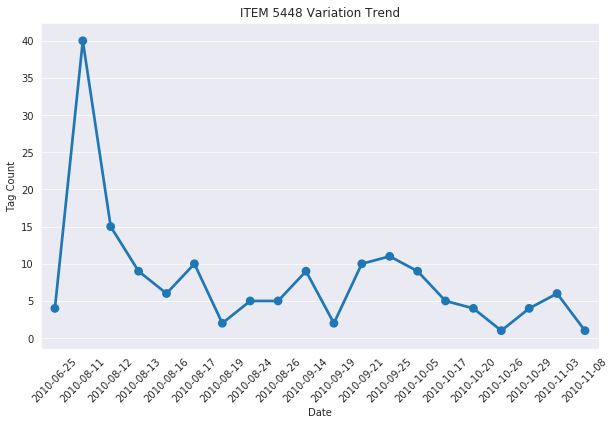

In [80]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")

plt.xticks(rotation=45)
plt.title("ITEM 5448 Variation Trend")

Item_5448["Tag Count"] = Item_5448["ItemID"]
sns.pointplot(x=Item_5448.index,y="Tag Count",data=Item_5448)

## 最近最热门

### 数据集

In [17]:
from main.util import delicious_reader

data = delicious_reader.read_tag_time("data/delicious-2k/user_taggedbookmarks-timestamps.dat")
data = [[user_id,item_id,ui_time] for user_id, item_id, tag_id, ui_time in data]

### 模型

In [26]:
from imp import reload
from main.chapter5 import most_popularity
reload(most_popularity)

model = most_popularity.RecentPopular()
model.train(data)

### 推荐

In [32]:
print("推荐的最近热门商品ID:{0}".format(model.recommend(alpha=0.1)))

推荐的最近热门商品ID:[5448, 8981, 11115, 1752, 2720, 1087, 7535, 1303, 4114, 4041]
